In [161]:
from sklearn import cluster
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# 5.0 Aplicaciones de Clustering

Para este ejercicio vamos a trabajar con una imagen satelital multiespectral proveniente de Sentinel-2. 

Sentinel-2 es un programa de observación terrestre desarrollada por la ESA para proveer imagenes terrestres
que permitan monitorear la evolución de las zonas de vegetación, suelo, agua para estudios científicos y para 
la gestión de los desastres naturales. Está compuesto por dos satélites Sentinel-2A y Sentinel-2B.

El primer satélite, el Sentinel-2A se lanzó  2015  y Sentinel-2B se lanzó en marzo del 2017.

Fuente * https://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2

La imagen para trabajar en esta oportunidad corresponde a una imagen tomada en la banda infrarroja
(Banda 8 del satellite) de la Bahía de Gibraltar en España con la que trabajaremos utilizando librería GDAL.

Este ejemplo ha sido adaptado de https://medium.com/@h4k1m0u/clustering-a-satellite-image-with-scikit-learn-14adb2ca3790

## 5.1 Geospatial Data Abstraction Library (GDAL)

Es una libreria de datos geoespaciales (datos espaciales georreferenciados) desarrollada la Open Source Geospatial 
Foundation.

## Ejemplo 1 Detección de Agua

In [162]:
dataset = gdal.Open('data/kmeans-b8.tif') #Abrir la imgaen
band = dataset.GetRasterBand(1) #Seleccionar la banda 1

In [163]:
img = band.ReadAsArray()  #Pasarlo a un arreglo

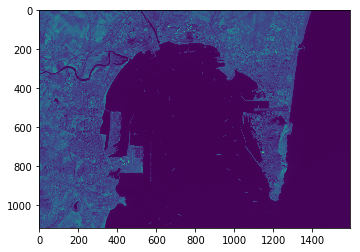

In [164]:
plt.imshow(img)
plt.show()

In [165]:
X = img.reshape((-1, 1)) #Pasar a una dimensión

In [166]:
k_means = cluster.KMeans(n_clusters=2) #Clusterizar
_ = k_means.fit(X)

In [167]:
X_clustered = k_means.labels_ #Extraer los labels
X_clustered = X_clustered.reshape(img.shape) #Pasar a dos dimensiones para graficar

In [168]:
X_clustered

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int32)

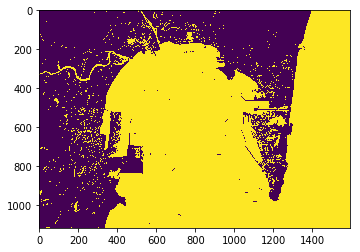

In [169]:
plt.imshow(X_clustered)
plt.show()

In [170]:
#Guardar Imagen
driver = gdal.GetDriverByName('GTiff')
x_size = img.shape[1]
y_size = img.shape[0]
dataset = driver.Create('test.tif', x_size, y_size, eType=gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(X_clustered)
dataset.FlushCache() 

## 5.2 DBSCAN

DBSCAN es otro tipo de técnica de agrupación. Este algoritmo, dado un conjunto de puntos en algún espacio, 
agrupa los puntos que están muy juntos.

En comparación con el agrupamiento basado en centroide como K-Means, el agrupamiento basado en densidadad permite identificar valores atípicos en los datos.


La idea de la clase de hoy  es explicar como podemos utilizar este algoritmo para resolver uno de los problemas de la tarea que involucra reconocimiento facial.

Pero antes de esto, introduciremos el algoritmo utilzando un ejemplo simple tomado de https://www.datacamp.com/community/tutorials/dbscan-macroscopic-investigation-python


## Ejemplo 2: Caracterización de Clientes

Supongamos que trabajamos en un supermercado y queremos mejorar nuestras ventas recomendando productos relevantes a nuestros clientes. 

No sabemos exactamente lo que buscan nuestros clientes, pero a partir de un conjunto de datos podriamos querer predecir y recomendar 
un producto relevante a un cliente específico. Podemos aplicar el DBSCAN a nuestro conjunto de datos y encontrar clústeres basados en los productos que los usuarios han comprado. Usando estos clusters podemos encontrar similitudes entre los clientes.

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Importar archivo.csv 
df = pd.read_csv("customers.csv");

print(df.head())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB
None


In [5]:
df.drop(["Channel", "Region"], axis = 1, inplace = True)

In [6]:
print(df.head())

   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0  12669  9656     7561     214              2674        1338
1   7057  9810     9568    1762              3293        1776
2   6353  8808     7684    2405              3516        7844
3  13265  1196     4221    6404               507        1788
4  22615  5410     7198    3915              1777        5185


Podemos segmentar clientes en base a su consumo anual de sólo dos categorías. 

In [7]:
df = df[["Fresh", "Milk"]]

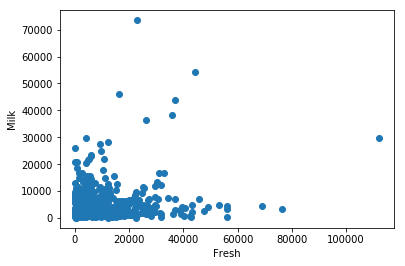

In [8]:
x = df['Fresh']
y = df['Milk']
plt.scatter(x,y)
plt.xlabel("Fresh")
plt.ylabel("Milk")
plt.show()

In [9]:
#Pasando el data frame a un arreglo
df = df.as_matrix().astype("float32", copy = False)
df

/Users/daniela/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[1.26690e+04, 9.65600e+03],
       [7.05700e+03, 9.81000e+03],
       [6.35300e+03, 8.80800e+03],
       [1.32650e+04, 1.19600e+03],
       [2.26150e+04, 5.41000e+03],
       [9.41300e+03, 8.25900e+03],
       [1.21260e+04, 3.19900e+03],
       [7.57900e+03, 4.95600e+03],
       [5.96300e+03, 3.64800e+03],
       [6.00600e+03, 1.10930e+04],
       [3.36600e+03, 5.40300e+03],
       [1.31460e+04, 1.12400e+03],
       [3.17140e+04, 1.23190e+04],
       [2.12170e+04, 6.20800e+03],
       [2.46530e+04, 9.46500e+03],
       [1.02530e+04, 1.11400e+03],
       [1.02000e+03, 8.81600e+03],
       [5.87600e+03, 6.15700e+03],
       [1.86010e+04, 6.32700e+03],
       [7.78000e+03, 2.49500e+03],
       [1.75460e+04, 4.51900e+03],
       [5.56700e+03, 8.71000e+02],
       [3.12760e+04, 1.91700e+03],
       [2.63730e+04, 3.64230e+04],
       [2.26470e+04, 9.77600e+03],
       [1.61650e+04, 4.23000e+03],
       [9.89800e+03, 9.61000e+02],
       [1.42760e+04, 8.03000e+02],
       [4.11300e+03,

In [10]:
stscaler = StandardScaler().fit(df)
df = stscaler.transform(df)

dbsc = DBSCAN(eps = .5, min_samples = 15).fit(df)

In [11]:
labels = dbsc.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0,
        0, -1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

Text(0,0.5,'Milk  (scaled)')

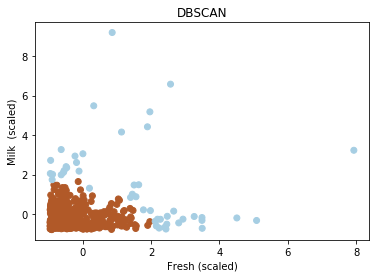

In [12]:
plt.scatter(df[:,0], df[:,1],c=labels, cmap='Paired')
plt.title("DBSCAN")
plt.xlabel("Fresh (scaled)")
plt.ylabel("Milk  (scaled)")


# 6.0 Reconocimiento Facial

Para comprender cómo funciona el reconocimiento facial, primero debemos tener una idea del concepto de vector de características.

Por ejemplo, supongamos que deseamos identificar qué rostro está presente 
en una imagen dada, hay varias cosas que podemos ver como un patrón:

- Razon ente el alto/ancho de una cara.
- Color de la cara.
- Color de los ojos
- Tamaño de algunas partes de la cara como labios, nariz, etc.

El desafío de Computer Vision es encontrar la forma de convertir una cara particular en números para entregarsela a 
los algoritmos de aprendizaje automático.

En concreto, lo que queremos hacer es entregarle un vector de caracteristicas a un algoritmo de machine learning.

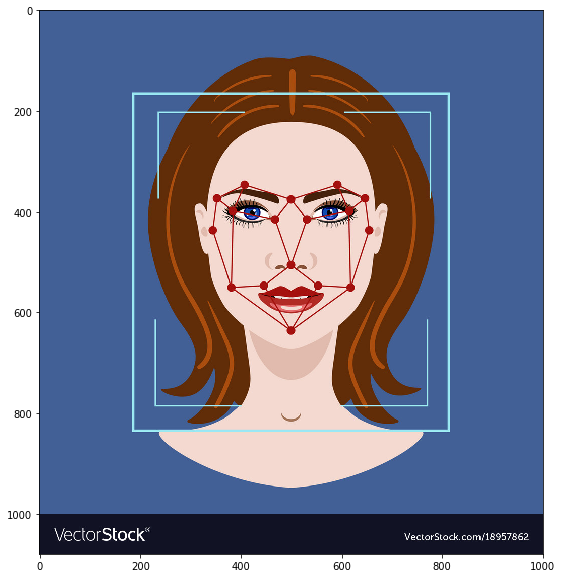

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
cara = np.array(Image.open('data/face_recognition.jpg'))
plt.figure(figsize=(10, 10))
plt.imshow(cara)

Supongamos entonces que para una imagen hemos medido los siguientes atributos:

- Altura de la cara: 23.1 cm
- Ancho de la cara: 15.8 cm
- Color medio de la cara (R, G, B): (255, 224, 189)
- Ancho de labios: 5.2 cm
- Altura de la nariz:  4.4 cm

Si queremos representar la imagen en un vector nos quedaria algo así:
    
face_vector = (23.1, 15.8, 255, 224, 189, 5.2, 4.4)

Hoy en día sabemos que un vector de caracteristicas de cinco dimensiones no es suficiente para representar un cara, ademas necesitamos de algoritmos que permitan detectar las caracteristicas automaticamente y convertirlas a un vector de carectrisiticas.

## 6.1 Face_Recognition

Es una librería que reconoce y manipule caras https://github.com/ageitgey/face_recognition
    
Para instalarla primero necesitaran instalar dlib 

Pueden instalarla ejecutando pip install dlib

https://pypi.org/project/dlib/

Luego de instalar dlib pueden instalar face_recognition usando ejecutando pip install face_recognition
    
https://pypi.org/project/face_recognition/
    


## Face Recognition y DBSCAN

In [27]:
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os

In [28]:
#Listar las imagenes a las que queremos extraer un vector
imagePaths = list(paths.list_images('face-clustering/dataset'))

In [29]:
imagePaths

['face-clustering/dataset/00000038.jpg',
 'face-clustering/dataset/00000010.jpg',
 'face-clustering/dataset/00000004.jpg',
 'face-clustering/dataset/00000005.jpg',
 'face-clustering/dataset/00000011.jpg',
 'face-clustering/dataset/00000039.jpg',
 'face-clustering/dataset/00000007.jpg',
 'face-clustering/dataset/00000013.jpg',
 'face-clustering/dataset/00000012.jpg',
 'face-clustering/dataset/00000006.jpg',
 'face-clustering/dataset/00000002.jpg',
 'face-clustering/dataset/00000016.jpg',
 'face-clustering/dataset/00000017.jpg',
 'face-clustering/dataset/00000003.jpg',
 'face-clustering/dataset/00000015.jpg',
 'face-clustering/dataset/00000001.jpg',
 'face-clustering/dataset/00000029.jpg',
 'face-clustering/dataset/00000028.jpg',
 'face-clustering/dataset/00000000.jpg',
 'face-clustering/dataset/00000014.jpg',
 'face-clustering/dataset/00000107.jpg',
 'face-clustering/dataset/00000113.jpg',
 'face-clustering/dataset/00000073.jpg',
 'face-clustering/dataset/00000067.jpg',
 'face-clusterin

In [30]:
#Detectar caras en las 129 imágenes

data = []

for (i, imagePath) in enumerate(imagePaths):
    print("Procesando imagen {}/{}".format(i + 1,len(imagePaths)))
    print(imagePath)
    image = cv2.imread(imagePath)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = face_recognition.face_locations(rgb,model='cnn') #Detectando las caras
    
    #Creando los vectores
    encodings = face_recognition.face_encodings(rgb, boxes)

    # Construyendo un diccionario con en el nombre de la imagen, el lugar donde esta la cara y el 
    # vector de caracteristicas
    d = [{"imagePath": imagePath, "loc": box, "encoding": enc}
        for (box, enc) in zip(boxes, encodings)]
    data.extend(d)

# Guardando los vectores en un formato en que no me importa la serializacion
f = open('encodings', "wb")
f.write(pickle.dumps(data))
f.close()



Procesando imagen 1/129
face-clustering/dataset/00000038.jpg
Procesando imagen 2/129
face-clustering/dataset/00000010.jpg
Procesando imagen 3/129
face-clustering/dataset/00000004.jpg
Procesando imagen 4/129
face-clustering/dataset/00000005.jpg
Procesando imagen 5/129
face-clustering/dataset/00000011.jpg
Procesando imagen 6/129
face-clustering/dataset/00000039.jpg
Procesando imagen 7/129
face-clustering/dataset/00000007.jpg
Procesando imagen 8/129
face-clustering/dataset/00000013.jpg
Procesando imagen 9/129
face-clustering/dataset/00000012.jpg
Procesando imagen 10/129
face-clustering/dataset/00000006.jpg
Procesando imagen 11/129
face-clustering/dataset/00000002.jpg
Procesando imagen 12/129
face-clustering/dataset/00000016.jpg
Procesando imagen 13/129
face-clustering/dataset/00000017.jpg
Procesando imagen 14/129
face-clustering/dataset/00000003.jpg
Procesando imagen 15/129
face-clustering/dataset/00000015.jpg
Procesando imagen 16/129
face-clustering/dataset/00000001.jpg
Procesando imagen

In [14]:
#Guardando los vectores cuando si me importa la serializacion
with open('encodings.txt', 'w') as f:
    for item in data:
        f.write("%s\n" % item)

### ¿Qué puedes hacer con pickle?

Pickling es útil para aplicaciones cuando quieres guardar los datos del resultado de un programa 
en el disco con los que quieres continuar trabajando en más adelante. También se puede usar para enviar datos 
a través de un protocolo de transmisión o para almacenar objetos de Python en una base de datos. Pickle es muy útil
cuando se trabaja con algoritmos de aprendizaje automático y se desea guardar los resultados para poder hacer nuevas predicciones en un momento posterior, sin tener que volver 
a escribir todo o entrenar el modelo nuevamente.

### ¿Qué puede ser guardado con pickle?

- Booleans
- Ints
- Floats
- Números complejos
- Strings
- Tuples
- Lists
- Diccionaries

### ¿Cuando no usar pickle?

Si quieres utilizar datos en diferentes lenguajes de programación, no se recomienda pickle, ya que este es específico 
de Python. Lo mismo vale para las diferentes versiones de Python. Unpickling un archivo que fue seleccionado en una 
versión diferente de Python puede no funcionar siempre correctamente, por lo que debes asegurarte de estar usando 
la misma versión. También debe intentar no deserializar los datos de una fuente no confiable. 
Un código malicioso dentro del archivo puede ejecutarse al deserializar.

Fuente: https://www.datacamp.com/community/tutorials/pickle-python-tutorial

### Unpickling 

In [21]:
import numpy as np
import pickle

data = pickle.loads(open('encodings', "rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]

In [22]:
#Nombre de la imagen
data[0]['imagePath']

'face-clustering/dataset/00000038.jpg'

In [23]:
#Recuperar la sección de la imagen donde se detectó la cara
(arriba, derecha, abajo, iz) = data[0]["loc"]
arriba, abajo, iz, derecha

(169, 373, 1014, 1218)